In [2]:
import pandas as pd
import json
import gzip
from tqdm import tqdm
import statistics
import math

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

In [3]:
total_video_date = pd.read_csv("total_count.csv")
total_video_date['upload_date'] = pd.to_datetime(total_video_date['upload_date'])
total_video_date = total_video_date.sort_values('upload_date')
total_video_date['upload_month'] = total_video_date['upload_date'].dt.to_period('M')
total_video = total_video_date.groupby('upload_month')['value'].sum().reset_index()

def get_counter(df_metadata: pd.DataFrame):
    df_meta = df_metadata.copy()
    df_meta.dropna(subset=["upload_month"])

    date_count = df_meta["upload_month"].value_counts().to_dict()
    
    return Counter(date_count)

def plot_video(csv_name):
    df_meta = pd.read_csv(csv_name)
    df_meta.upload_date = pd.to_datetime(df_meta.upload_date)

    df_meta['upload_month'] = df_meta['upload_date'].dt.to_period('M')
    counter = get_counter(df_meta)

    # Convert the total videos dataframe to a dictionary
    total_videos_dict = total_video.set_index('upload_month')['value'].to_dict()    

    # Calculate the percentage of videos
    sorted_dates = sorted(total_videos_dict.keys())
    sorted_percentages = [
        (counter.get(pd.Period(date, freq='M'), 0)/ total_count)
        for date, total_count in total_videos_dict.items()
    ]


    month_percentage_pairs = list(zip(sorted_dates, sorted_percentages))
    max_month, max_percentage = max(month_percentage_pairs, key=lambda x: x[1])
    max_total_videos = math.floor(total_videos_dict[max_month])
    print(f"The month with the maximum percentage is {max_month}, the percentage is {max_percentage}, and the total video number is {max_total_videos}")


    # Plotting the histogram
    plt.figure(figsize=(20, 6))

    # Plot the first subplot
    plt.subplot(1, 2, 1)
    df_meta['upload_month'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title('Videos Uploaded by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Videos')

    # Plot the second subplot
    plt.subplot(1, 2, 2)

    # Plot the second subplot
    plt.subplot(1, 2, 2)
    sorted_dates = [pd.Period(date).to_timestamp().to_pydatetime() for date in sorted_dates]

    plt.plot(sorted_dates, sorted_percentages, marker='o', color='orange')
    plt.title('Percentage of Videos')
    plt.xlabel('Date')
    plt.ylabel('Scaled Percentage of Total Videos')
    plt.xticks(rotation=45)

    # Set the y-axis range based on the maximum scaled_percentage
    max_scaled_percentage = max(sorted_percentages)
    print(max_scaled_percentage)
    plt.ylim(0, max_scaled_percentage)  # Add some padding to the top of the range

    plt.tight_layout()
    plt.show()


def plot_channel(csv_name):
    df_meta = pd.read_csv(csv_name)
    df_meta_channel = df_meta.sort_values(by="upload_date").drop_duplicates(subset = ['channel_id', 'upload_month'], keep='first').copy()
    plt.figure(figsize=(10, 6))
    df_meta_channel['upload_month'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    

    upload_month    value
0        2005-05        1
1        2005-07      123
2        2005-08       33
3        2005-09        8
4        2005-10       14
..           ...      ...
169      2019-07  1472685
170      2019-08  1448736
171      2019-09  1460297
172      2019-10   116040
173      2019-11       66

[174 rows x 2 columns]


In [65]:
ice_keywords = "ice bucket challenge|ALS challenge|ALS ice bucket|"

pokemon_keywords = "pokemon go|pokémon go"

black_keywords = "black friday"

word_lists_climate = [
    "climate change",
    "global warming",
    "air pollution",
    "greenhouse effect",
    "carbon emissions",
    "carbon footprint",
    "carbon tax"
]
climate_keywords = "|".join(word_lists_climate)

word_lists_privacy = [
    "Online Privacy",
    "Data Security",
    "data breaches",
    "surveillance",
    "perosnal information",
    "data protection",
    "data privacy",
    "privacy policy",
    "privacy protection"
]
privacy_keywords = "|".join(word_lists_privacy)

In [74]:
keywords_dict = {
    "ice": ice_keywords
    # "pokemon": pokemon_keywords
    # "black_friday": black_keywords
    # "climate": climate_keywords,
    # "privacy": privacy_keywords
}

In [75]:
##### metadata #####

def df_filter(df_metadata: pd.DataFrame, keywords: str):
    """
    Function to build and filter dataframe.
    A record would be kept if all its text fields (description, tags, title) match with at least one keyword specifed above
    """

    df_meta = df_metadata.copy()
    df_meta.dropna(subset=["description", "tags", "title", "upload_date"])

    filter_condition1 = df_meta["description"].str.lower().str.contains(keywords).astype(int)
    filter_condition2 = df_meta["tags"].str.lower().str.contains(keywords).astype(int)
    filter_condition3 = df_meta["title"].str.lower().str.contains(keywords).astype(int)

    filter_condition = filter_condition1 + filter_condition2 + filter_condition3
    df_meta = df_meta[filter_condition >= 2]

    return df_meta.copy()


metadata_df = {}
for topic in keywords_dict.keys():
    metadata_df[topic] = []

tmp_metadata = []
# counter = Counter()  # count how many videos uploaded per day

# Specify the file path and batch size
file_path = './data/yt_metadata_en.jsonl.gz'
batch = 200000

with gzip.open(file_path, mode="rb") as f:
    for idx, row in enumerate(tqdm(f, total=72924794)):
        try:
            json_dict = json.loads(row.decode("utf-8"))
            tmp_metadata.append(json_dict)

            if (idx + 1) % batch == 0 and idx != 0:
                df_meta = pd.DataFrame(tmp_metadata)
                # cur_counter = get_counter(df_meta)
                # counter = counter + cur_counter

                for topic, keywords in keywords_dict.items():
                    metadata_df[topic].append(df_filter(df_meta, keywords))
                tmp_metadata = []
        except:
            continue
    
    if tmp_metadata:
        df_meta = pd.DataFrame(tmp_metadata)
        # cur_counter = get_counter(df_meta)
        # counter = counter + cur_counter
        
        for topic, keywords in keywords_dict.items():
            metadata_df[topic].append(df_filter(df_meta, keywords))
        tmp_metadata = []

 29%|██▉       | 20992861/72924794 [07:36<09:43, 89059.27it/s]  

: 

In [7]:
pd.set_option('display.max_colwidth', None)

In [14]:
for topic, filtered_df in metadata_df.items():
    metadata_df[topic] = pd.concat(filtered_df)
    metadata_df[topic].to_csv("./metadata_%s.csv"%topic, index=False)

The month with the maximum percentage is 2014-08, the percentage is 0.007142565424356421, and the total video number is 440738
0.007142565424356421


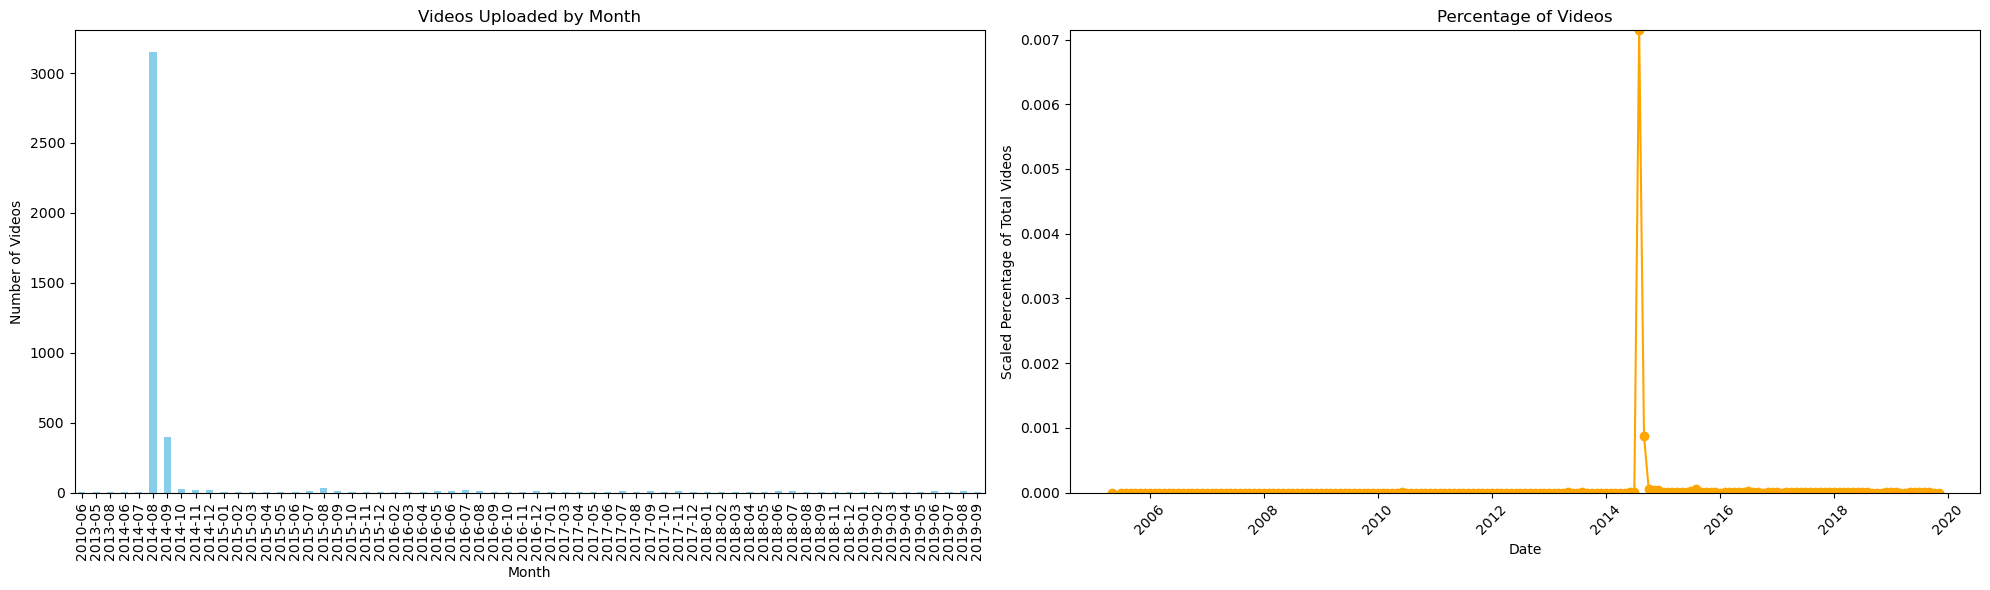

In [4]:
plot_video("./metadata_ice.csv")

The month with the maximum percentage is 2016-07, the percentage is 0.00960981453872763, and the total video number is 785447
0.00960981453872763


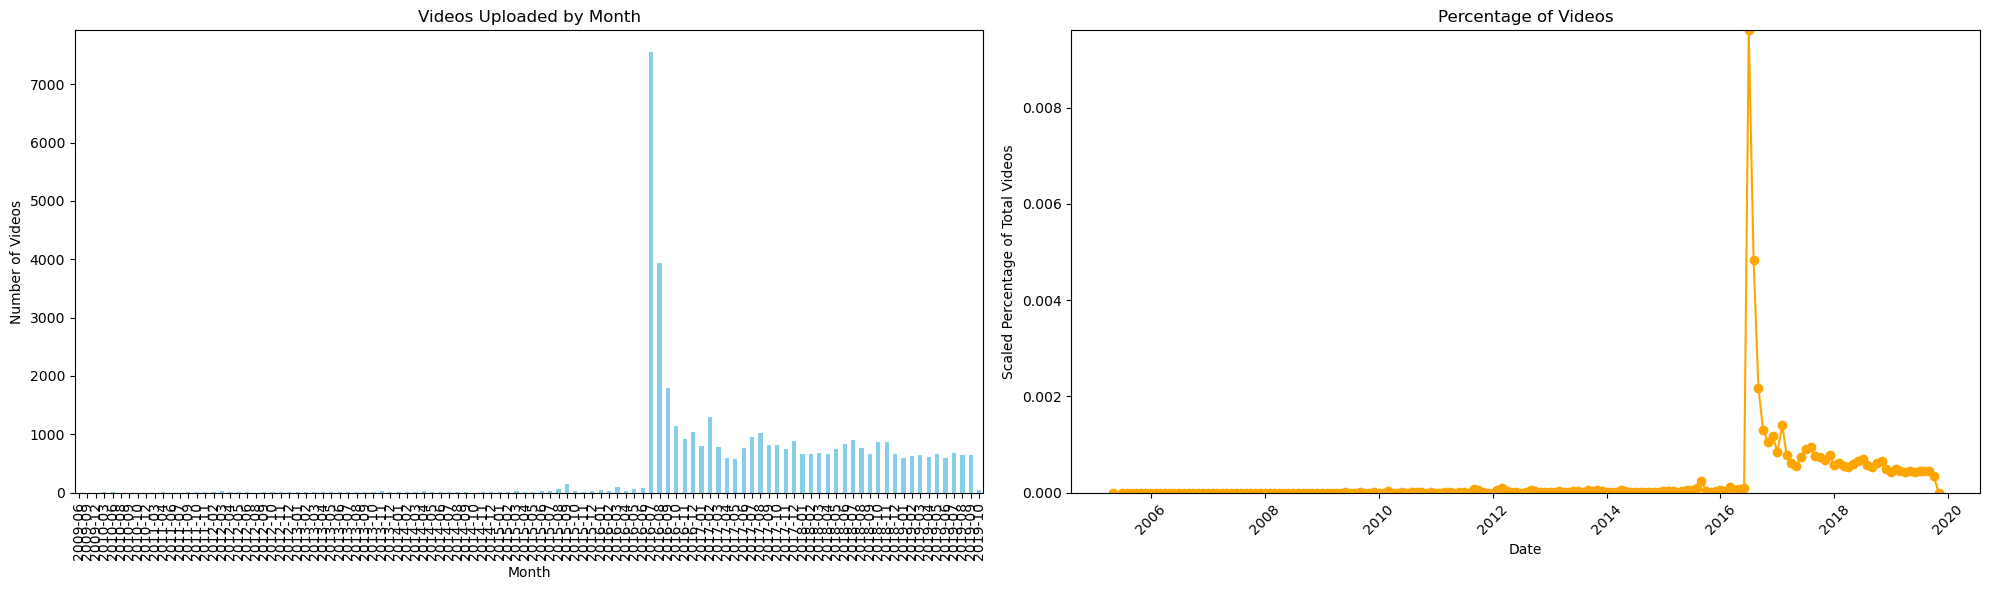

In [73]:
plot_video("./metadata_pokemon.csv")

The month with the maximum percentage is 2018-11, the percentage is 0.002788619498632259, and the total video number is 1336145
0.002788619498632259


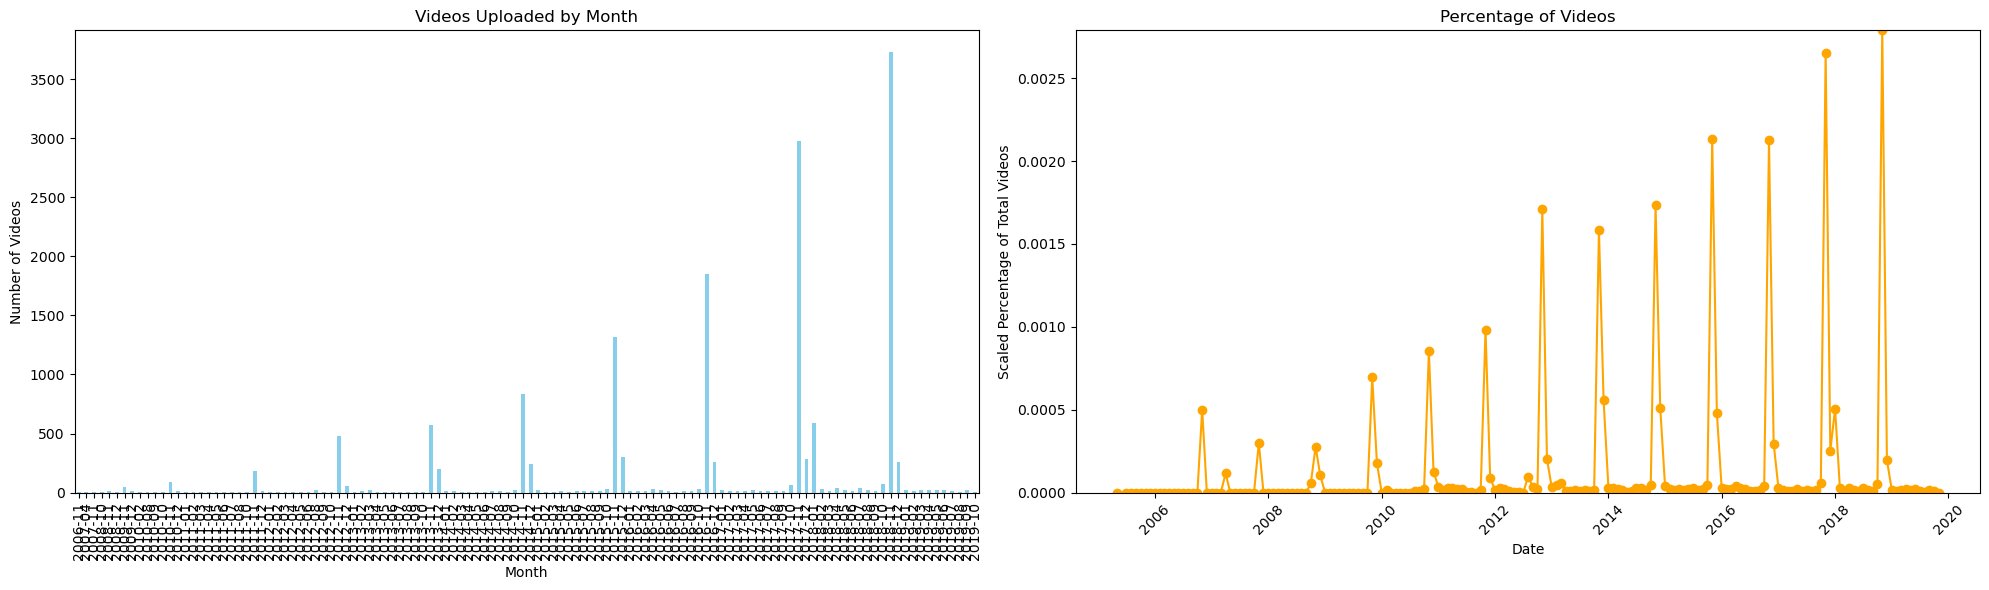

In [70]:
plot_video("./metadata_black_friday.csv")

The month with the maximum percentage is 2009-12, the percentage is 0.0029848518767256176, and the total video number is 67005
0.0029848518767256176


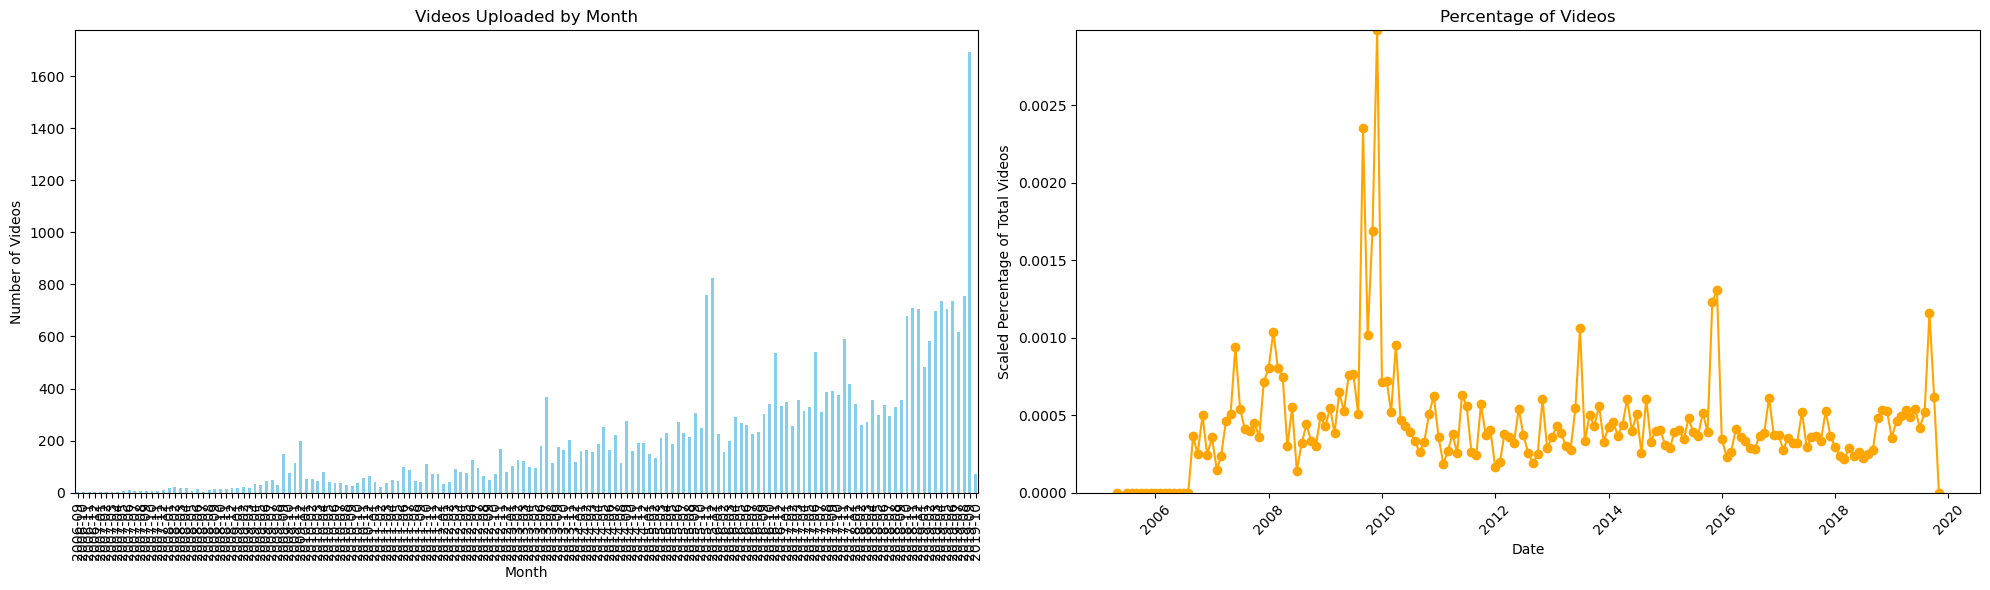

In [71]:
plot_video("./metadata_climate.csv")

The month with the maximum percentage is 2006-03, the percentage is 0.002369668246445498, and the total video number is 422
0.002369668246445498


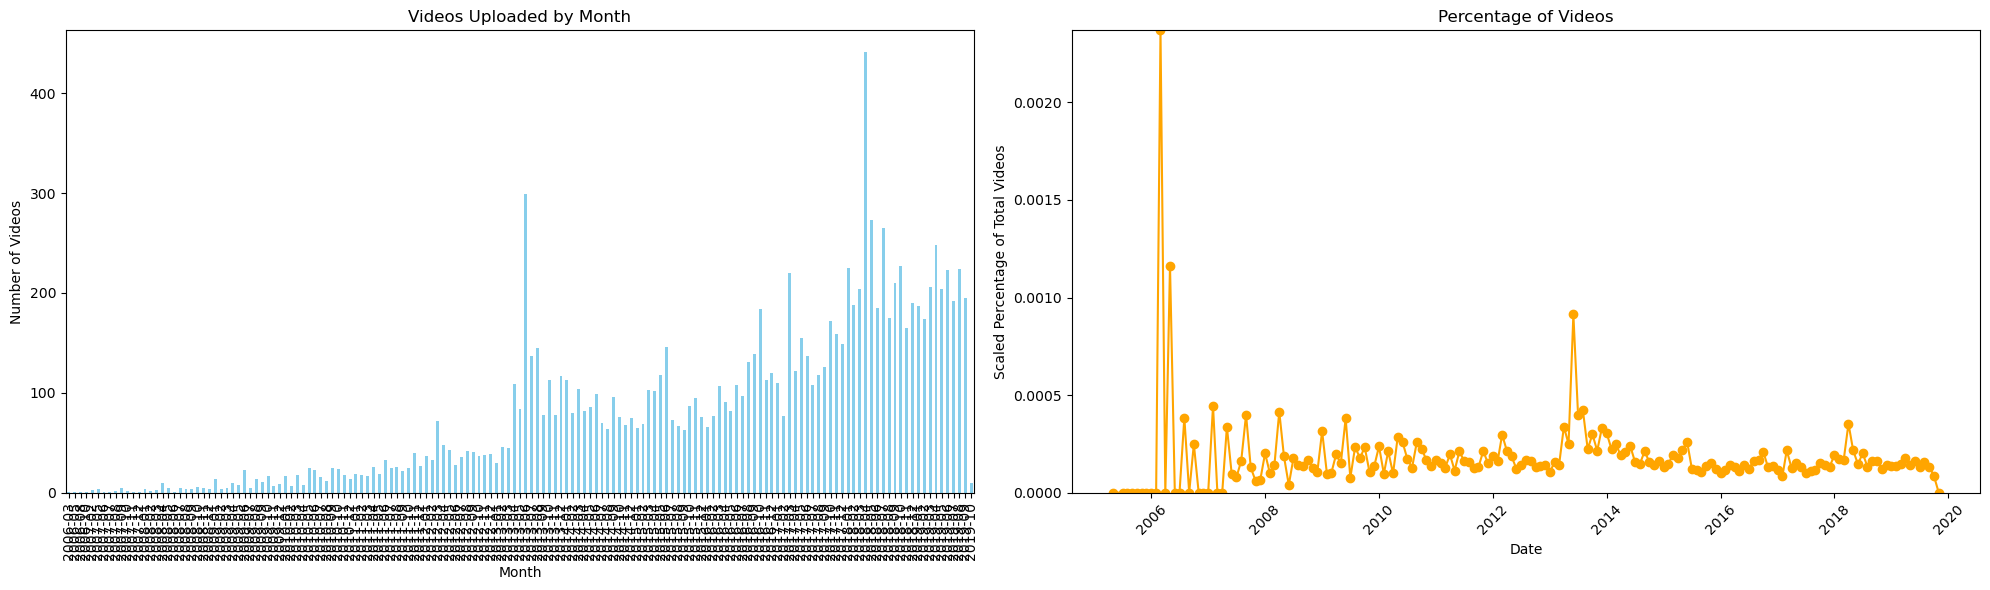

In [72]:
plot_video("./metadata_privacy.csv")